##Fangyuan Deng
##5074
##HW 1

###Get data in and set up X_train, X_test, y_train objects

In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [85]:
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall()

In [86]:
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

Country or region  GDP per capita  Social support  Healthy life expectancy  \
0              Peru           0.960           1.274                    0.854   
1         Nicaragua           0.694           1.325                    0.835   
2            Greece           1.181           1.156                    0.999   
3             Qatar           1.684           1.313                    0.871   
4        Uzbekistan           0.745           1.529                    0.756   

   Freedom to make life choices  Generosity  Perceptions of corruption  \
0                         0.455       0.083                      0.027   
1                         0.435       0.200                      0.127   
2                         0.067       0.000                      0.034   
3                         0.555       0.220                      0.167   
4                         0.631       0.322                      0.240   

         name    region                       sub-region  Terrorist_attacks  
0        Peru  Americas  Latin America and the Caribbean          18.000000  
1   Nicaragua  Americas  Latin America and the Caribbean         125.611111  
2      Greece    Europe                  Southern Europe         112.000000  
3       Qatar      Asia                     Western Asia          57.333333  
4  Uzbekistan      Asia                     Central Asia         125.611111

###1. Explore bivariate results (Use visualizations!)

###Describe any relationships you see between particular features and the target variable


Text(0, 0.5, 'Healthy life expectancy')

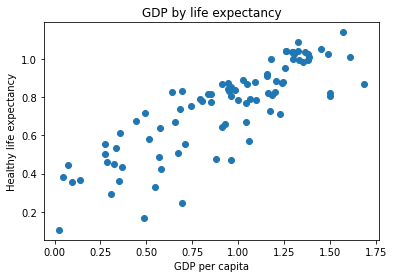

In [87]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.scatter(X_train['GDP per capita'], X_train['Healthy life expectancy'])
plt.title("GDP by life expectancy")
plt.xlabel('GDP per capita')
plt.ylabel('Healthy life expectancy')

Text(0, 0.5, 'Social support')

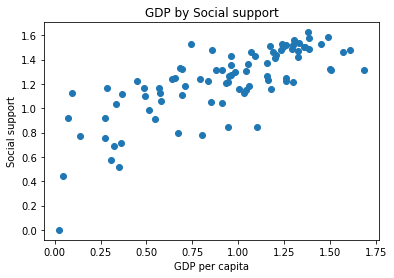

In [88]:
plt.scatter(X_train['GDP per capita'], X_train['Social support'])
plt.title("GDP by Social support")
plt.xlabel('GDP per capita')
plt.ylabel('Social support')

Text(0, 0.5, 'Generosity')

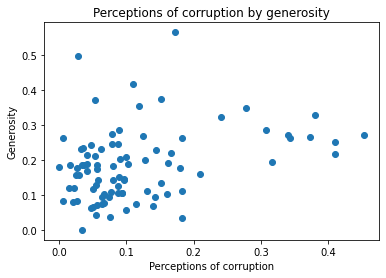

In [89]:
plt.scatter(X_train['Perceptions of corruption'], X_train['Generosity'])
plt.title("Perceptions of corruption by generosity")
plt.xlabel('Perceptions of corruption')
plt.ylabel('Generosity')

We can see that both GDP per capita and healthy life expectancy have increased. In addition, GDP per capita also has a positive correlation with social support.

####Preprocess data using Sklearn Column Transformer/ Write and Save Preprocessor function


In [90]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [91]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [92]:
# check shape of X data after preprocessing it using our new function
preprocessor(X_train).shape

(88, 26)

###2.Examine features that predict happiness categories using one or more models that allow for automatic feature selection.
###Explain any meaningful findings

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators': np.arange(100, 300, 500),'max_depth':[3, 5, 7]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)

#use meta model methods to fit score and predict model:
gridmodel.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))

best mean cross-validation score: 0.705
best parameters: {'max_depth': 7, 'n_estimators': 100}


In a Random Forest Classifier model, with GridSearchCV tunning the parameter, we can see that the best parameter for max_depth is 7, for n_eatimators is 100.

###3.Experiment with different prediction models to try to predict World Happiness well (Fit and compare, at minimum, three models)


####Fit model on preprocessed data and save preprocessor function and model 


In [94]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=800, max_depth=5)
model.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.9431818181818182

####Save preprocessor function to local "preprocessor.zip" file

In [95]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


####Save model to local ".onnx" file

In [96]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

####Generate predictions from X_test data and submit model to competition

In [97]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [98]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [99]:
#Submit Model 1: 

#-- Generate predicted values (Model 1)
prediction_labels = model.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                           custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): random forest classifier
Provide any useful notes about your model (optional): random forest classifier

Your model has been submitted as model version 333

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [100]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

In [101]:
# Submit a second model using GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators': np.arange(100, 300, 500),'max_depth':[3, 5, 7]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)

#use meta model methods to fit score and predict model:
gridmodel.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))

best mean cross-validation score: 0.682
best parameters: {'max_depth': 5, 'n_estimators': 100}


In [102]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(gridmodel, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("gridmodel.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [103]:
#Submit Model 2: 

#-- Generate predicted values
prediction_labels = gridmodel.predict(preprocessor(X_test))

# Submit to Competition Leaderboard
mycompetition.submit_model(model_filepath = "gridmodel.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                           custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): gridmodel
Provide any useful notes about your model (optional): griidmodel

Your model has been submitted as model version 334

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [104]:
# Get leaderboard

data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

In [111]:
# Compare two or more models
data=mycompetition.compare_models([333,334], verbose=1)
mycompetition.stylize_compare(data)

In [106]:
# Submit a third model with deep learning models
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

feature_count=preprocessor(X_train).shape[1] #count features in input data

keras_model = Sequential()
keras_model.add(Dense(128, input_dim=feature_count, activation='relu'))
keras_model.add(Dense(32, activation='relu'))
keras_model.add(Dense(32, activation='relu'))
keras_model.add(Dense(32, activation='relu'))

keras_model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
keras_model.fit(preprocessor(X_train), y_train, ## Note that keras models require a one-hot-encoded y_train object
               batch_size = 20, 
               epochs = 100, validation_split=0.25)  

Epoch 1/100
4/4 [==============================] - 1s 70ms/step - loss: 1.6262 - accuracy: 0.1364 - val_loss: 1.6266 - val_accuracy: 0.1818
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 1.6173 - accuracy: 0.1667 - val_loss: 1.6250 - val_accuracy: 0.1818
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 1.6103 - accuracy: 0.2121 - val_loss: 1.6236 - val_accuracy: 0.1818
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 1.6038 - accuracy: 0.2879 - val_loss: 1.6219 - val_accuracy: 0.1818
Epoch 5/100
4/4 [==============================] - 0s 19ms/step - loss: 1.5986 - accuracy: 0.3333 - val_loss: 1.6201 - val_accuracy: 0.2273
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 1.5924 - accuracy: 0.3030 - val_loss: 1.6186 - val_accuracy: 0.2273
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 1.5871 - accuracy: 0.3030 - val_loss: 1.6170 - val_accuracy: 0.2273
Epoch 8/100
4/4 [====

In [113]:
# Save keras model to ONNX file 

from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [108]:
# Submit model 3: 

#-- Generate predicted y values
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 3 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                           custom_metadata={"team":"9"})

3/3 [==============================] - 0s 4ms/step
Insert search tags to help users find your model (optional): keras
Provide any useful notes about your model (optional): keras

Your model has been submitted as model version 335

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [109]:
# Check leaderboard 

data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

In [141]:
# Compare two or more models
data=mycompetition.compare_models([334,338], verbose=1)
mycompetition.stylize_compare(data)

####Submit my best model

In [133]:
from sklearn.ensemble import RandomForestClassifier

best_model = RandomForestClassifier(n_estimators=100, max_depth=7)
best_model.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
best_model.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

1.0

My best predict model is Random Forest Classifier model. After discussed with my team, I set the hyper-parameter as following: n_estimators=100, max_depth=7, which has the best score to predict happiness.

In [134]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(best_model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("best_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [135]:
#Submit Best Model: 

#-- Generate predicted y values (Model 2)
prediction_labels = best_model.predict(preprocessor(X_test))

# Submit Best Model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "best_model.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip",
                           custom_metadata={"team":"9"})

Insert search tags to help users find your model (optional): best
Provide any useful notes about your model (optional): best

Your model has been submitted as model version 338

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [136]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)